### Conexión a ruta de Proyecto

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd 'drive/MyDrive/PROYECTOS_DIPLOMADO/VISION'

/content/drive/MyDrive/PROYECTOS_DIPLOMADO/VISION


In [ ]:
!ls

'Copy of U-NET_JOSE.ipynb'
'Copy of U-NET_JOSE_labels.ipynb'
'Copy of U-NET_JOSE_mas_epocas.ipynb'
'Copy of Untitled0_JOSE.ipynb'
'Copy of YOLO_JOSE.ipynb'
 dataset_profa
 datasets
 GoogleNet_DAR_1.ipynb
 GoogleNet_DAR.ipynb
 GoogleNet.ipynb
 GoogleNet_JIMM_1.ipynb
 MobileNet_DAR_1.ipynb
 MobileNet.ipynb
 Mobilenet_JIMM_1.ipynb
 models
'Proyecto de Visión Artificial - Segmentación y Clasificación de Árboles.gslides'
 ResNet_DAR_1.ipynb
 Resnet_JIMM_1.ipynb
 runs
 U-NET_JOSE.ipynb
 unet_model_seg_4.pth
 unet_model_seg.pth
 unet_model_seg_weights_4.pth
 unet_model_seg_weights.pth
 Untitled0.ipynb
 Untitled0_JOSE.ipynb
 urban-street_-tree-classification-DatasetNinja
 urban-street_-tree-DatasetNinja
 YOLO2
 YOLO_JOSE.ipynb
 yolov8n.pt
 yolov8s.pt


### Librerías

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.4/799.4 kB 20.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 21.0 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from PIL import Image, UnidentifiedImageError
import os
import json
import numpy as np
import base64
from io import BytesIO
import zlib
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO

### Clase TreeDataset

In [ ]:
path_dataset = 'urban-street_-tree-DatasetNinja'

In [ ]:
import json

with open(path_dataset + '/meta.json') as f:
    metadata = json.load(f)

classes = {(i): cls['title'] for i, cls in enumerate(metadata['classes'])}
num_classes = len(classes)

print(f"Número de clases: {num_classes}")
print(f"Clases: {classes}")

Número de clases: 22
Clases: {0: 'acer_palmatum', 1: 'cedrus_deodara', 2: 'celtis_sinensis', 3: 'cinnamomum_camphora_(linn)_presl', 4: 'elaeocarpus_decipiens', 5: 'flowering_cherry', 6: 'ginkgo_biloba', 7: 'koelreuteria_paniculata', 8: 'liquidambar_formosana', 9: 'liriodendron_chinense', 10: 'magnolia_grandiflora_l', 11: 'magnolia_liliflora_desr', 12: 'michelia_chapensis', 13: 'osmanthus_fragrans', 14: 'photinia_serratifolia', 15: 'platanus', 16: 'prunus_cerasifera_f._atropurpurea', 17: 'salix_babylonica', 18: 'sapindus_saponaria', 19: 'styphnolobium_japonicum', 20: 'triadica_sebifera', 21: 'zelkova_serrata'}


In [ ]:
len(classes)

22

In [ ]:
# Define TreeDataset
class TreeDataset(Dataset):
    def __init__(self, root, classes, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "img"))))
        self.anns = list(sorted(os.listdir(os.path.join(root, "ann"))))
        self.classes = classes
        self.class_to_idx = {v: k for k, v in classes.items()}

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "img", self.imgs[idx])
        ann_path = os.path.join(self.root, "ann", self.anns[idx])

        img = Image.open(img_path).convert("RGB")
        with open(ann_path) as f:
            ann = json.load(f)

        height, width = ann['size']['height'], ann['size']['width']
        #print(f"Height: {height}, Width: {width}")
        boxes = []
        labels = []

        for obj in ann['objects']:
            xmin, ymin, xmax, ymax = self.create_mask_from_bitmap(obj['bitmap'], ann['size']['height'], ann['size']['width'])
            box = [xmin, ymin, xmax, ymax]
            #print(box)
            boxes.append(box)
            labels.append(self.class_to_idx[obj['classTitle']])

        img = np.array(img).astype(np.float32) / 255.0

        if self.transforms:
            # Aplicar transformaciones a la imagen
            transformed = self.transforms(image=img, bboxes=boxes, labels=labels)
            img = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['labels']

        # Convertir img y boxes a tensores de PyTorch
        #img = torch.tensor(img).permute(2, 0, 1)  # Convertir a CHW
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        return img, target

    def __len__(self):
        return len(self.imgs)

    def create_mask_from_bitmap(self, bitmap, height, width):
        try:
            bitmap_data = bitmap['data']
            if isinstance(bitmap_data, str):
                bitmap_data = base64.b64decode(bitmap_data)

            compressed, decompressed_data = self.is_compressed(bitmap_data)
            if compressed:
                bitmap_data = decompressed_data

            image = Image.open(BytesIO(bitmap_data))
            mask = np.array(image)

            x, y = bitmap['origin']
            x_max, y_max = x + mask.shape[1], y + mask.shape[0]

            return x, y, x_max, y_max
            # return mask
        except (base64.binascii.Error, UnidentifiedImageError) as e:
            print(f"Error al procesar la imagen: {e}")
            print(f"Datos del bitmap: {bitmap['data']}")
            return np.zeros((height, width), dtype=np.uint8)

    def is_compressed(self, data):
        try:
            decompressed_data = zlib.decompress(data)
            return True, decompressed_data
        except zlib.error:
            return False, None

    def resize_mask(self, mask, original_size, transformed_size):
        original_height, original_width = original_size
        transformed_height, transformed_width = transformed_size

        resized_mask = Image.fromarray(mask).resize((transformed_width, transformed_height), resample=Image.BILINEAR)
        resized_mask = np.array(resized_mask)

        return resized_mask

    def get_classes(self):
        return self.classes

    def get_class_to_idx(self):
        return self.class_to_idx

    def get_num_classes(self):
        return len(self.classes)

    def get_img_path(self, idx):
        return os.path.join(self.root, "img", self.imgs[idx])

    def get_ann_path(self, idx):
        return os.path.join(self.root, "ann", self.anns[idx])

    def get_img_shape(self, idx):
        img_path = self.get_img_path(idx)
        img = Image.open(img_path).convert("RGB")
        return img.size

    def get_total_images(self):
        return len(self.imgs)

    def get_random_img_path(self):
        idx = np.random.randint(len(self.imgs))
        return self.get_img_path(idx)

    def get_random_ann_path(self):
        idx = np.random.randint(len(self.anns))
        return self.get_ann_path(idx)

    def get_random_img_and_ann_paths(self):
        idx = np.random.randint(len(self.imgs))
        img_path = self.get_img_path(idx)
        ann_path = self.get_ann_path(idx)
        return img_path, ann_path

    def get_img_and_mask(self, idx):
        img, target = self.__getitem__(idx)
        return img, target

    def get_random_img_and_mask(self):
        idx = np.random.randint(len(self.imgs))
        img, target = self.__getitem__(idx)
        return img, target

    def get_random_img(self):
        img_path = self.get_random_img_path()
        img = Image.open(img_path).convert("RGB")
        return img

### Carga de Dataset y Preprocesamiento

In [ ]:
def get_transform(train):
    if train:
        return A.Compose([
            A.Resize(height=1024, width=768),  # Ajusta el tamaño de la imagen y máscara
            A.RandomBrightnessContrast(p=0.2),  # Brillo/contraste aleatorio con probabilidad 0.2
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return A.Compose([
            A.Resize(height=1024, width=768),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Create datasets and dataloaders
dataset_train = TreeDataset(os.path.join(path_dataset, 'train'), classes, get_transform(train=True))
dataset_val = TreeDataset(os.path.join(path_dataset, 'val'), classes, get_transform(train=False))
dataset_test = TreeDataset(os.path.join(path_dataset, 'test'), classes, get_transform(train=False))

data_loader_train = DataLoader(dataset_train, batch_size=2, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
data_loader_val = DataLoader(dataset_val, batch_size=2, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
data_loader_test = DataLoader(dataset_test, batch_size=2, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
import yaml
# Function to convert annotation format to YOLO format
def convert_to_yolo_format(boxes, labels, img_width, img_height):
    yolo_annotations = []
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box
        x_center = (x_min + x_max) / 2.0 / img_width
        y_center = (y_min + y_max) / 2.0 / img_height
        width = (x_max - x_min) / img_width
        height = (y_max - y_min) / img_height
        yolo_annotations.append(f"{label} {x_center} {y_center} {width} {height}")
    return yolo_annotations

# Function to prepare YOLO dataset structure from DataLoader
def prepare_yolo_dataset_from_dataloader(data_loader, dataset_split, images_path, labels_path):
    for imgs, targets in data_loader:
        for img, target in zip(imgs, targets):
            img = img.permute(1, 2, 0).numpy() * 255  # Convert image back to numpy array and scale
            img = Image.fromarray(img.astype(np.uint8))
            img_id = len(list(images_path.glob(f"{dataset_split}/*.jpg")))
            img_save_path = images_path / dataset_split / f"{img_id}.jpg"
            img.save(img_save_path)

            img_width, img_height = img.size
            print(f"Image ID: {img_id}, Width: {img_width}, Height: {img_height}")
            #print(target)
            print(target['boxes'])
            print(target['labels'].numpy())
            yolo_annotations = convert_to_yolo_format(target['boxes'].numpy(), target['labels'].numpy(), img_width, img_height)
            label_save_path = labels_path / dataset_split / f"{img_id}.txt"
            with open(label_save_path, "w") as f:
                f.write("\n".join(yolo_annotations))

# Function to create the dataset.yml file
def create_dataset_yml_file(new_dataset_path, classes):
    dataset = {
        'train': str(new_dataset_path / "images" / "train"),
        'val': str(new_dataset_path / "images" / "val"),
        'test': str(new_dataset_path / "images" / "test"),
        'nc': len(classes),
        'names': list(classes.keys())
    }

    with open(new_dataset_path / "dataset.yml", "w") as f:
        yaml.dump(dataset, f)

    print("Dataset prepared and dataset.yml file created.")

In [ ]:
from pathlib import Path

# Paths to the new dataset structure
new_dataset_path = Path("/content/drive/.shortcut-targets-by-id/1t2J8Q1IpvHK3pPOnBHLyYRJH9Ugc1A9N/PROYECTOS_DIPLOMADO/VISION/YOLO2/yolo_dataset")
print(new_dataset_path)
images_path = new_dataset_path / "images"
labels_path = new_dataset_path / "labels"
print(images_path)
print(labels_path)

/content/drive/.shortcut-targets-by-id/1t2J8Q1IpvHK3pPOnBHLyYRJH9Ugc1A9N/PROYECTOS_DIPLOMADO/VISION/YOLO2/yolo_dataset
/content/drive/.shortcut-targets-by-id/1t2J8Q1IpvHK3pPOnBHLyYRJH9Ugc1A9N/PROYECTOS_DIPLOMADO/VISION/YOLO2/yolo_dataset/images
/content/drive/.shortcut-targets-by-id/1t2J8Q1IpvHK3pPOnBHLyYRJH9Ugc1A9N/PROYECTOS_DIPLOMADO/VISION/YOLO2/yolo_dataset/labels


In [ ]:
# Create the new dataset structure
for split in ["train", "val", "test"]:
    os.makedirs(images_path / split, exist_ok=True)
    os.makedirs(labels_path / split, exist_ok=True)

In [ ]:
%ls

'Copy of U-NET_JOSE.ipynb'
'Copy of U-NET_JOSE_labels.ipynb'
'Copy of U-NET_JOSE_mas_epocas.ipynb'
'Copy of Untitled0_JOSE.ipynb'
 dataset_profa/
 datasets/
 GoogleNet_DAR_1.ipynb
 GoogleNet_DAR.ipynb
 GoogleNet.ipynb
 GoogleNet_JIMM_1.ipynb
 MobileNet_DAR_1.ipynb
 MobileNet.ipynb
 models/
'Proyecto de Visión Artificial - Segmentación y Clasificación de Árboles.gslides'
 ResNet_DAR_1.ipynb
 Resnet_JIMM_1.ipynb
 runs/
 U-NET_JOSE.ipynb
 Untitled0.ipynb
 Untitled0_JOSE.ipynb
 urban-street_-tree-classification-DatasetNinja/
 urban-street_-tree-DatasetNinja/
 YOLO2/
 YOLO_JOSE.ipynb
 yolov8n.pt
 yolov8s.pt


In [ ]:
# Prepare YOLO dataset from DataLoader
prepare_yolo_dataset_from_dataloader(data_loader_train, "train", images_path, labels_path)
prepare_yolo_dataset_from_dataloader(data_loader_val, "val", images_path, labels_path)
prepare_yolo_dataset_from_dataloader(data_loader_test, "test", images_path, labels_path)



Se truncaron las últimas líneas 5000 del resultado de transmisión.
tensor([[1.2546e+02, 2.5397e-01, 7.6775e+02, 8.8533e+02]])
[9]
Image ID: 2303, Width: 768, Height: 1024
tensor([[2.5397e-01, 1.1225e+02, 7.0146e+02, 8.5816e+02]])
[7]
Image ID: 2304, Width: 768, Height: 1024
tensor([[451.5555, 252.1905, 652.6984, 505.9048],
        [ 35.0476, 277.8413, 251.1746, 525.2064],
        [283.1746, 375.1111, 416.7619, 518.0952]])
[10 10 10]
Image ID: 2305, Width: 768, Height: 1024
tensor([[153.6508, 101.3333, 673.5238, 894.7302]])
[8]
Image ID: 2306, Width: 768, Height: 1024
tensor([[  61.4603,  178.2857,  743.8730, 1019.6826]])
[14]
Image ID: 2307, Width: 768, Height: 1024
tensor([[  0.0000,  32.0000, 730.6667, 899.8095]])
[14]
Image ID: 2308, Width: 768, Height: 1024
tensor([[  42.4127,   75.1746,  768.0000, 1022.9841]])
[11]
Image ID: 2309, Width: 768, Height: 1024
tensor([[318.9841,  62.9841, 766.4762, 716.9524]])
[3]
Image ID: 2310, Width: 768, Height: 1024
tensor([[ 96.5079, 101.8413, 67

NameError: name 'yaml' is not defined

In [ ]:
# Create the dataset.yml file
create_dataset_yml_file(new_dataset_path, classes)

Dataset prepared and dataset.yml file created.


In [ ]:
data_loader_train.dataset.get_total_images()

3168

In [ ]:
# Visualizar las imágenes y las máscaras
for imgs, targets in data_loader_train:
    print(targets[0]['labels'])
    print(targets[0]['boxes'])
    for img, target in zip(imgs, targets):
        img = img.permute(1, 2, 0).numpy()  # Reordenar los ejes del tensor para que sean compatibles con matplotlib
        print(img.shape)
        break  # Mostrar solo el primer batch para evitar demasiadas visualizaciones
    break

tensor([21])
tensor([[200.1270, 125.9683, 594.7936, 746.9207]])
(1024, 768, 3)


Boxes shape: (1, 4)


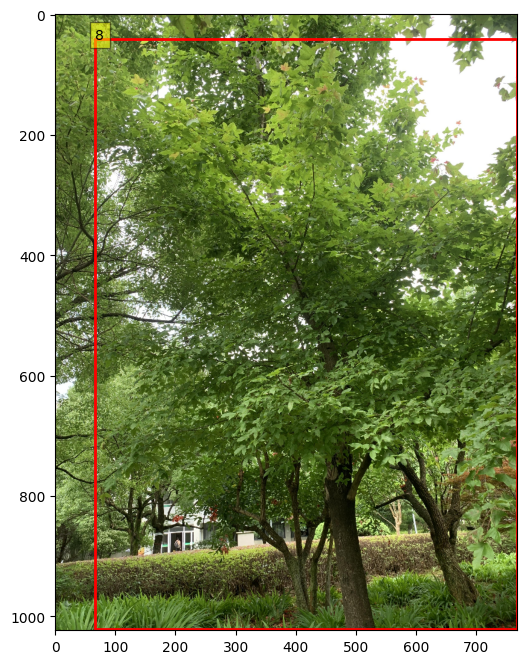

Boxes shape: (1, 4)


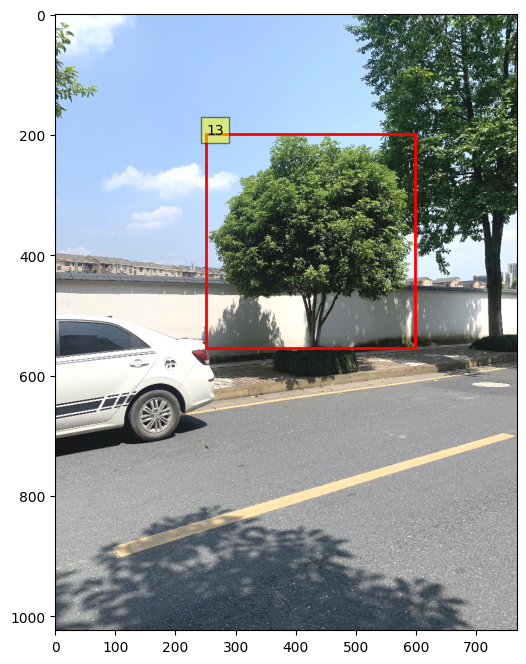

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Visualizar las imágenes y las bounding boxes
for imgs, targets in data_loader_train:
    for img, target in zip(imgs, targets):
        img = img.permute(1, 2, 0).numpy()  # Reordenar los ejes del tensor para que sean compatibles con matplotlib

        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(img)

        # Dibujar las bounding boxes y los labels
        boxes = target['boxes'].numpy()
        labels = target['labels'].numpy()
        print("Boxes shape:", boxes.shape)  # Imprimir la forma de las bounding boxes para debug

        for box, label in zip(boxes, labels):
            # box en formato [xmin, ymin, xmax, ymax]
            xmin, ymin, xmax, ymax = box
            width = xmax - xmin
            height = ymax - ymin

            # Crear un rectángulo para la bounding box
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Añadir el label encima de la bounding box
            ax.text(xmin, ymin, f'{label}', bbox=dict(facecolor='yellow', alpha=0.5))

        plt.show()
        #break  # Mostrar solo el primer batch para evitar demasiadas visualizaciones
    break


### Transfer Learning

In [ ]:
# En esta linea se ejecutaron tanto la YOLO v8n con 3 epocas y la YOLO v8s con 10 epocas, archivos resultantes se encuentran en el entregable
!yolo train model=yolov8s.pt data='YOLO2/yolo_dataset/dataset.yml' epochs=10 imgsz=640

Ultralytics YOLOv8.2.50 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=YOLO2/yolo_dataset/dataset.yml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True